In [1]:
import numpy as np  
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=80

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "GestureDataset/DifferentGestures",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2879 files belonging to 11 classes.


In [4]:
class_names = dataset.class_names
class_names

['1finger',
 '2finger',
 '3finger',
 '4finger',
 'kitli',
 'neutral',
 'pinch',
 'pinky',
 'snake',
 'thumbsup',
 'yoyo']

In [5]:
len(dataset)

91

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 0  4  9  3  8  7  7  7  6  7  7  7  8  5  0  5  3  2  9  4  5  4  6  2
  8 10  7  3  0  9  3  4]


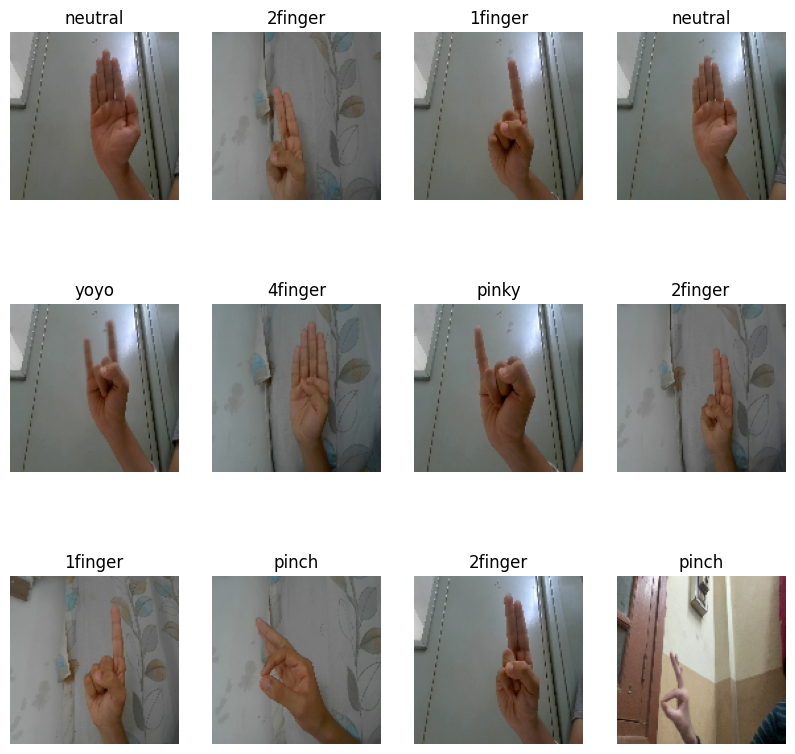

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_ds = dataset.take(72)
len(train_ds)

72

In [10]:
test_ds = dataset.skip(72)
len(test_ds)

19

In [11]:
val_size=0.1
len(dataset)*val_size

9.1

In [12]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [13]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

72

In [17]:
len(val_ds)

9

In [18]:
len(test_ds)

10

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 40

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
72/72 [==============================] - 12s 160ms/step - loss: 0.1981 - accuracy: 0.9209 - val_loss: 0.2195 - val_accuracy: 0.9201
Epoch 2/30
72/72 [==============================] - 10s 142ms/step - loss: 0.1707 - accuracy: 0.9323 - val_loss: 0.1962 - val_accuracy: 0.9306
Epoch 3/30
72/72 [==============================] - 12s 161ms/step - loss: 0.1796 - accuracy: 0.9358 - val_loss: 0.2090 - val_accuracy: 0.9306
Epoch 4/30
72/72 [==============================] - 10s 144ms/step - loss: 0.1425 - accuracy: 0.9495 - val_loss: 0.1517 - val_accuracy: 0.9583
Epoch 5/30
72/72 [==============================] - 11s 156ms/step - loss: 0.1606 - accuracy: 0.9455 - val_loss: 0.1486 - val_accuracy: 0.9375
Epoch 6/30
72/72 [==============================] - 12s 163ms/step - loss: 0.1541 - accuracy: 0.9473 - val_loss: 0.1928 - val_accuracy: 0.9306
Epoch 7/30
72/72 [==============================] - 13s 176ms/step - loss: 0.1598 - accuracy: 0.9319 - val_loss: 0.1218 - val_accuracy: 0.9583

In [30]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 1s 56ms/step - loss: 0.1799 - accuracy: 0.9250


In [31]:
scores

[0.1798981875181198, 0.925000011920929]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: 4finger
1/1 [==============================] - 0s 251ms/step
predicted label: 4finger


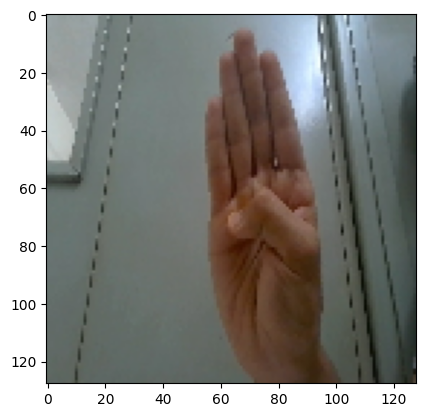

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 15ms/step


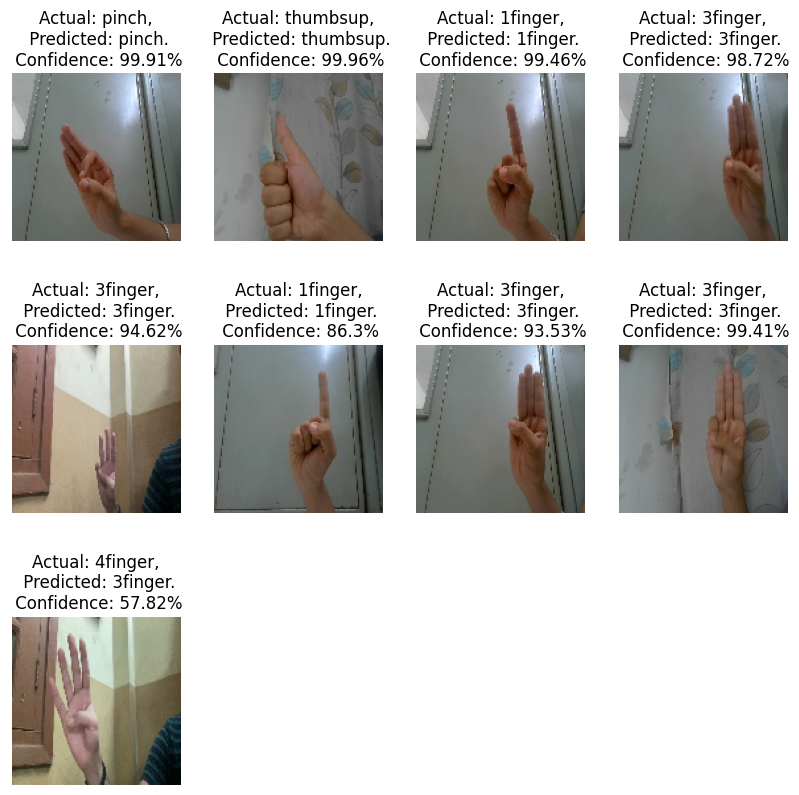

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
model_version = 1
model.save(f"../Models/{model_version}")  

INFO:tensorflow:Assets written to: ../Models/1/assets


INFO:tensorflow:Assets written to: ../Models/1/assets
